In [1]:
import os
import json
import time
import copy
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import lovely_tensors as lt # can be removed
import numpy as np
import dill
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from fl2o.optimizee import MLPOptee, CustomParams
from fl2o.optimizee_modules import MetaParameter
from fl2o.optimizer import GD, Adam, FGD, AFOGD, CFGD, CFGD_ClosedForm, L2O_Update
from fl2o.l2o import L2O
from fl2o.data import MNIST, CustomTask, generate_least_squares_task, H1, H2, H3
from fl2o.training import do_fit, find_best_lr, meta_train, get_optimal_lr, n_step_lookahead_lr_search_hfunc_tanh_twolayer_optee
from fl2o.utils import dict_to_str, plot_log, plotter, plot_metrics, apply_publication_plt_settings, plot_strategy

lt.monkey_patch() # can be removed

DATA_PATH = os.getenv("DATA_PATH")
CKPT_PATH = os.getenv("CKPT_PATH")
DEVICE = os.getenv("DEVICE", "cpu")
# DEVICE = "cuda:0"

print(f"{DATA_PATH=}\n{CKPT_PATH=}\n{DEVICE=}")

DATA_PATH='/home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/data'
CKPT_PATH='/home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/ckpt'
DEVICE='cuda:3'


In [2]:
### load previous checkpoint (and skip meta-training of a new l2O optimizer)
ckpt = torch.load(
    os.path.join(
        CKPT_PATH,
        "l2o",
        "23-07_00-10__L2O__CFGD",
        # "ckpt_1200.pt"
        "meta_training",
        "200.pt",
    ),
    map_location=torch.device(DEVICE),
    pickle_module=dill,
)
config = ckpt["config"]
config["device"] = DEVICE
print(json.dumps(config, indent=4, default=str))

l2o_dict = ckpt["l2o_dict"]
l2o_dict_best = ckpt["l2o_dict_best"]
if "opter" not in l2o_dict_best:
    l2o_dict_best["best_l2o_dict"]["opter"] = config["opter"]["opter_cls"](**config["opter"]["opter_config"])
    l2o_dict_best["best_l2o_dict"]["opter"].load_state_dict(l2o_dict_best["best_l2o_dict"]["opter_state_dict"])
    l2o_dict_best["best_l2o_dict"]["meta_opter"] = config["meta_training_config"]["meta_opter_cls"](
        params=l2o_dict_best["best_l2o_dict"]["opter"].parameters(),
        **config["meta_training_config"]["meta_opter_config"],
    )
    l2o_dict_best["best_l2o_dict"]["meta_opter"].load_state_dict(l2o_dict_best["best_l2o_dict"]["meta_opter_state_dict"])
l2o_dict_best["best_l2o_dict"]["opter"].device = DEVICE
l2o_dict_best["best_l2o_dict"]["opter"].to(DEVICE)
l2o_dict["opter"].device = DEVICE
l2o_dict["opter"].to(DEVICE)
log = ckpt["log"]

### l2o
# ckpt_2 = torch.load(
#     os.path.join(
#         CKPT_PATH,
#         "l2o",
#         "03-07_21-32__L2O__L2O_Update",
#         "ckpt.pt"
#         # "meta_training",
#         # "500.pt",
#     ),
#     map_location=torch.device(DEVICE),
#     pickle_module=dill,
# )
# l2o_dict_2 = ckpt_2["l2o_dict"]
# l2o_dict_best_2 = ckpt_2["l2o_dict_best"]
# config_2 = ckpt_2["config"]
# if "opter" not in l2o_dict_best_2:
#     l2o_dict_best_2["best_l2o_dict"]["opter"] = config_2["opter"]["opter_cls"](**config_2["opter"]["opter_config"])
#     l2o_dict_best_2["best_l2o_dict"]["opter"].load_state_dict(l2o_dict_best_2["best_l2o_dict"]["opter_state_dict"])
#     l2o_dict_best_2["best_l2o_dict"]["meta_opter"] = config_2["meta_training_config"]["meta_opter_cls"](
#         params=l2o_dict_best_2["best_l2o_dict"]["opter"].parameters(),
#         **config_2["meta_training_config"]["meta_opter_config"],
#     )
#     l2o_dict_best_2["best_l2o_dict"]["meta_opter"].load_state_dict(l2o_dict_best_2["best_l2o_dict"]["meta_opter_state_dict"])
# l2o_dict_best_2["best_l2o_dict"]["opter"].device = DEVICE
# l2o_dict_best_2["best_l2o_dict"]["opter"].to(DEVICE)
# l2o_dict_2["opter"].device = DEVICE
# l2o_dict_2["opter"].to(DEVICE)
# log_2 = ckpt_2["log"]
# print(json.dumps(config_2, indent=4, default=str))

{
    "time": "23-07_00-10",
    "data": {
        "data_cls": "<class 'fl2o.data.MNIST'>",
        "data_config": {
            "device": "cuda:3",
            "preload": true
        }
    },
    "optee": {
        "optee_cls": "<class 'fl2o.optimizee.MLPOptee'>",
        "optee_config": {
            "layer_sizes": [
                20
            ],
            "act_fn": "ReLU()",
            "device": "cuda:3"
        }
    },
    "opter": {
        "opter_cls": "<class 'fl2o.l2o.L2O'>",
        "opter_config": {
            "in_dim": 3,
            "out_dim": 3,
            "hidden_sz": 40,
            "in_features": [
                "grad",
                "iter_num_enc"
            ],
            "device": "cuda:3",
            "base_opter_cls": "<class 'fl2o.optimizer.CFGD'>",
            "base_opter_config": {
                "lr": 0.1,
                "alpha": null,
                "beta": null,
                "c": null,
                "s": 1,
                "version": "

## MNIST

### Meta-training

In [2]:
config = {
    "time": datetime.now().strftime("%d-%m_%H-%M"),
}

### data (task)
config["data"] = {
    "data_cls": MNIST,
}
config["data"]["data_config"] = {
    "device": DEVICE,
    "preload": True,
}

### optimizee
config["optee"] = {
    "optee_cls": MLPOptee,
    "optee_config": {
        "layer_sizes": [20],
        "act_fn": nn.ReLU(),
        "device": DEVICE,
    },
}

### optimizer L2O-CFGD
config["opter"] = {
    "opter_cls": L2O,
    "opter_config": {
        "in_dim": 3, # len(in_features) + 1
        "out_dim": 3,
        "hidden_sz": 40,
        "in_features": ("grad", "iter_num_enc"),
        "device": DEVICE,
        "base_opter_cls": CFGD,
        "base_opter_config": {
            "lr": 0.1,
            "alpha": None,
            "beta": None,
            "c": None,
            "s": 1,
            "version": "NA",
            "init_points": None,
            "detach_gauss_jacobi": True,
            "device": DEVICE,
        },
        "params_to_optimize": {
            "alpha": {
                "idx": 0,
                "act_fns": ("sigmoid",),
            },
            "beta": {
                "idx": 1,
                "act_fns": ("identity",),
            },
            "c": {
                "idx": 2,
                "act_fns": ("identity",),
            },
        },
    },
}

### optimizer L2O
# config["opter"] = {
#     "opter_cls": L2O,
#     "opter_config": {
#         "in_dim": 3, # len(in_features) + 1
#         "out_dim": 1,
#         "hidden_sz": 40,
#         "in_features": ("grad", "iter_num_enc"),
#         "base_opter_cls": L2O_Update,
#         "device": DEVICE,
#         "base_opter_config": {
#             "lr": 0.1,
#             "device": DEVICE,
#         },
#         "params_to_optimize": {
#             "update": {
#                 "idx": 0,
#                 "act_fns": ("identity",),
#             },
#         },
#     },
# }

### meta-training config
config["meta_training_config"] = {
    "meta_opter_cls": optim.Adam,
    "meta_opter_config": {
        "lr": 1e-3,
    },
    "n_runs": 600,
    "unroll": 30,
    "loggers": [
        # {
        #     "every_nth_run": 20,
        #     "logger_fn": partial(plotter, to_plot="c"),
        # }
    ],
}

### other
config.update({
    "n_iters": 200,
    "l2o_dict": None,
    "additional_metrics": {
    },
    "ckpt_config": {
        "ckpt_every_nth_run": 20,
        "ckpt_dir": os.path.join(
            CKPT_PATH,
            "l2o",
            config["time"] + "__"\
                + config["opter"]["opter_cls"].__name__ + "__"\
                + config["opter"]["opter_config"]["base_opter_cls"].__name__,
        ),
    },
    "device": DEVICE,
    "seed": 0,
})
config["ckpt_config"]["ckpt_dir_meta_training"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_training",
)
config["ckpt_config"]["ckpt_dir_meta_testing"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_testing",
)

### make dirs
os.makedirs(config["ckpt_config"]["ckpt_dir"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_training"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_testing"], exist_ok=True)

### save config
with open(os.path.join(config["ckpt_config"]["ckpt_dir"], "config.json"), "w") as f:
    json.dump(config, f, indent=4, default=str)

print(f"Path to checkpoints: {config['ckpt_config']['ckpt_dir']}")
print(os.path.basename(config["ckpt_config"]["ckpt_dir"]))

Path to checkpoints: /home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/ckpt/l2o/23-07_00-10__L2O__CFGD
23-07_00-10__L2O__CFGD


[INFO] Running on cuda:3
[INFO] Starting meta-training.
[INFO] Meta-training starts.
  [1/600]> sum(loss): 163.342  last(loss): 0.447
       > new best loss sum: 163.342
  [2/600]> sum(loss): 148.434  last(loss): 0.658
       > new best loss sum: 148.434
  [3/600]> sum(loss): 150.446  last(loss): 0.625
  [4/600]> sum(loss): 158.581  last(loss): 0.671
  [5/600]> sum(loss): 188.828  last(loss): 1.096
  [6/600]> sum(loss): 157.510  last(loss): 0.477
  [7/600]> sum(loss): 154.832  last(loss): 0.580
  [8/600]> sum(loss): 134.410  last(loss): 0.473
       > new best loss sum: 134.410
  [9/600]> sum(loss): 139.505  last(loss): 0.535
  [10/600]> sum(loss): 141.159  last(loss): 0.597
  [11/600]> sum(loss): 136.266  last(loss): 0.538
  [12/600]> sum(loss): 124.340  last(loss): 0.581
       > new best loss sum: 124.340
  [13/600]> sum(loss): 136.967  last(loss): 0.834
  [14/600]> sum(loss): 153.748  last(loss): 0.610
  [15/600]> sum(loss): 143.759  last(loss): 0.650
  [16/600]> sum(loss): 150.048

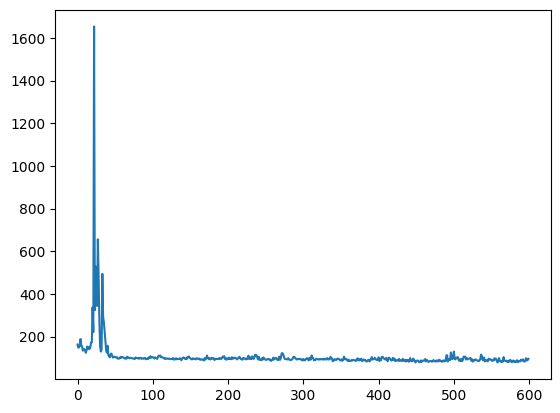

In [3]:
### meta train
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
l2o_dict, l2o_dict_best, log = meta_train(
    config=config,
    device=config["device"],
    ### keep meta-training
    # l2o_dict=l2o_dict,
    # l2o_dict_best=l2o_dict_best,
    # log=log,
)

### save checkpoint
torch.save({
    "l2o_dict": l2o_dict,
    "l2o_dict_best": l2o_dict_best,
    "log": log,
    "config": config,
}, os.path.join(config["ckpt_config"]["ckpt_dir"], "ckpt.pt"), pickle_module=dill)

plt.plot(log["loss_sum"])

In [5]:
### meta train
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
l2o_dict, l2o_dict_best, log = meta_train(
    config=config,
    device=config["device"],
    ### keep meta-training
    l2o_dict=l2o_dict,
    l2o_dict_best=l2o_dict_best,
    log=log,
)

### save checkpoint
torch.save({
    "l2o_dict": l2o_dict,
    "l2o_dict_best": l2o_dict_best,
    "log": log,
    "config": config,
}, os.path.join(config["ckpt_config"]["ckpt_dir"], "ckpt_1800.pt"), pickle_module=dill)

plt.plot(log["loss_sum"])

[INFO] Running on cuda:3
[INFO] Continuing meta-training.
[INFO] Meta-training starts.
  [1/400]> sum(loss): 79.368  last(loss): 0.293
  [2/400]> sum(loss): 82.381  last(loss): 0.291
  [3/400]> sum(loss): 85.707  last(loss): 0.223
  [4/400]> sum(loss): 77.728  last(loss): 0.326
  [5/400]> sum(loss): 83.224  last(loss): 0.240
  [6/400]> sum(loss): 79.862  last(loss): 0.296
  [7/400]> sum(loss): 82.028  last(loss): 0.289
  [8/400]> sum(loss): 77.417  last(loss): 0.293
  [9/400]> 

### Meta-testing

##### Config

In [7]:
n_test_runs = 3
test_run_iters = 1000
test_runs_seed = 1

update_config_base = dict()
update_config_base["n_iters"] = test_run_iters
update_config_base["optee"] = {
    "optee_cls": MLPOptee,
    "optee_config": {
        "layer_sizes": [20],
        "act_fn": nn.ReLU(),
        "device": DEVICE,
    },
}

update_config_base["additional_metrics"] = {
    # "cos_sim(d, x.grad)": lambda opter, **kwargs: \
    #     torch.cosine_similarity(
    #         opter.state[0]["last_update"].flatten() if "last_update" in opter.state[0] else opter.param_groups[0]["last_update"].flatten(),
    #         opter.state[0]["last_grad"].flatten() if "last_grad" in opter.state[0] else opter.param_groups[0]["last_grad"].flatten(),
    #         dim=0
    #     ).item(),
    # "last_lr": lambda opter, **kwargs: \
    #     opter.state[0]["last_lr"] if "last_lr" in opter.state[0] else opter.param_groups[0]["last_lr"],
}

runs = dict()

In [8]:
### GD
runs["GD"] = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": GD,
            "opter_config": {
                "lr": 0.3,
                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "color": "black",
        "linestyle": "dashed",
    },
    # "load_saved": False,
}

In [ ]:
### AT-CFGD hyperparam search
_tmp_optee = update_config_base["optee"]["optee_cls"](**update_config_base["optee"]["optee_config"])
# for alpha in [0.2, 0.4, 0.7, 0.9]:
#     for beta in [-30, -10, -2, 0, 2, 10, 30]:
#         for lr in [0.01, 0.1, 0.5, 1.0]:
for alpha in [0.6, 0.3]:
    for beta in [2, -1, -2, -10]:
        for lr in [0.1]:
            runs[r"AT-CFGD, $\alpha$=" + str(alpha) + r", $\beta$=" + str(beta) + f", lr={lr}"] = {
                "update_config": {
                    **update_config_base,
                    "opter": {
                        "opter_cls": CFGD,
                        "opter_config": {
                            "lr": lr,
                            "alpha": alpha,
                            "beta": beta,
                            "c": None,
                            "s": 1,
                            "n_hutchinson_steps": 5,
                            "version": "AT",
                            "init_points": [
                                [torch.randn_like(p, requires_grad=False, device=DEVICE)] for _, p in _tmp_optee.all_named_parameters()
                                # [torch.zeros_like(p, requires_grad=False, device=DEVICE)] for _, p in _tmp_optee.all_named_parameters()
                            ],
                            "device": DEVICE,
                        },
                    },
                },
                "plot_config": {
                    "linestyle": "dashed",
                },
                "load_saved": False,
            }

In [ ]:
### NA-CFGD
for lr in [0.02]:
    # for alpha in [0.9]:
    #     for beta in [0.]:
    #         for c in [-1.]:
    for alpha in [0.1]:
        for beta in [0]:
            for c in [0]:
                runs[r"NA-CFGD, $\alpha$=" + str(alpha)
                    + r" $\beta$=" + str(beta)
                    + r" $c$=" + str(c)
                    + r" $\eta$=" + str(lr)] = {
                    "update_config": {
                        **update_config_base,
                        "opter": {
                            "opter_cls": CFGD,
                            "opter_config": {
                                "lr": lr,
                                "alpha": alpha,
                                "beta": beta,
                                "c": torch.tensor([c], device=DEVICE).float(),
                                "s": 1,
                                "n_hutchinson_steps": 5,
                                "version": "NA",
                                "init_points": None,
                                "device": DEVICE,
                            },
                        },
                    },
                    "plot_config": {
                        "linestyle": "dashed",
                    },
                    "load_saved": False,
                }

In [ ]:
### AT-CFGD
_tmp_optee = update_config_base["optee"]["optee_cls"](**update_config_base["optee"]["optee_config"])
for lr in [0.1]:
    for alpha in [0.9]:
        for beta in [-0.2]:
            runs[r"AT-CFGD, $\alpha$=" + str(alpha)
                + r" $\beta$=" + str(beta)
                + r" $\eta$=" + str(lr)] = {
                "update_config": {
                    **update_config_base,
                    "opter": {
                        "opter_cls": CFGD,
                        "opter_config": {
                            "lr": lr,
                            "alpha": alpha,
                            "beta": beta,
                            "c": 0,
                            "s": 1,
                            "version": "AT",
                            "init_points": [
                                [torch.randn_like(p, requires_grad=False, device=DEVICE)] for _, p in _tmp_optee.all_named_parameters()
                            ],
                            "device": DEVICE,
                        },
                    },
                },
                "plot_config": {
                    "linestyle": "dashed",
                },
                "load_saved": False,
            }

In [ ]:
### L2O
runs["L2O"] = {
    "update_config": {
        "n_iters": update_config_base["n_iters"],
        "optee": update_config_base["optee"],
        "additional_metrics": {
            "cos_sim(d, x.grad)": lambda opter, **kwargs: \
                torch.cosine_similarity(
                    opter.base_opter.state[0]["last_update"].flatten(),
                    opter.base_opter.state[0]["last_grad"].flatten(),
                    dim=0
                ).item(),
            "last_lr": lambda opter, **kwargs: \
                opter.base_opter.state[0]["last_lr"].item() if type(opter.base_opter.state[0]["last_lr"]) == torch.Tensor else opter.base_opter.state[0]["last_lr"],
        },
        # "l2o_dict": l2o_dict_2,
        "l2o_dict": l2o_dict_best_2["best_l2o_dict"],
    },
    "plot_config": {
        "linestyle": "dashed",
    },
    "load_saved": False,
}

In [10]:
### L2O-CFGD
runs["L2O-CFGD"] = {
    "update_config": {
        "n_iters": update_config_base["n_iters"],
        "optee": update_config_base["optee"],
        "additional_metrics": {
            "c": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["c"].item() \
                # opter.base_opter.param_groups[0]["c"].detach().cpu().numpy() \
                [
                    opter.base_opter.param_groups[pg_i]["c"].detach().cpu().numpy()
                    for pg_i in range(len(opter.base_opter.param_groups))
                ] if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
            "alpha": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["alpha"].detach().cpu().numpy() \
                [
                    opter.base_opter.param_groups[pg_i]["alpha"].detach().cpu().numpy()
                    for pg_i in range(len(opter.base_opter.param_groups))
                ] if hasattr(opter, "base_opter") else opter.param_groups[0].get("alpha", None),
            "beta": lambda opter, **kwargs: \
                [
                    opter.base_opter.param_groups[pg_i]["beta"].detach().cpu().numpy()
                    for pg_i in range(len(opter.base_opter.param_groups))
                ] if hasattr(opter, "base_opter") else opter.param_groups[0].get("beta", None),
            # "grad": lambda opter, **kwargs: \
            #     opter.base_opter.state[0]["last_grad"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.state[0]["last_grad"].detach().cpu().numpy(),
            # "cos_sim(d, x.grad)": lambda opter, **kwargs: \
            #     torch.cosine_similarity(
            #         opter.base_opter.state[0]["last_update"].flatten(),
            #         opter.base_opter.state[0]["last_grad"].flatten(),
            #         dim=0
            #     ).item(),
        },
        # "l2o_dict": l2o_dict,
        "l2o_dict": l2o_dict_best["best_l2o_dict"],
    },
    "plot_config": {
        # "color": "orange",
        "linewidth": "1.5",
    },
    "load_saved": False,
}

In [11]:
### run all
print(f"Running:\n" + ",".join(list(runs.keys())))
for run_name in runs.keys():
    ### prepare run config
    run_config = copy.deepcopy(config)
    run_config["data"]["data_config"]["device"] = DEVICE
    if "update_config" in runs[run_name] and runs[run_name]["update_config"] is not None:
        run_config.update(runs[run_name]["update_config"])
    print(f"{run_name}:")

    ### remove all non-alphanumeric characters from run_name
    run_name_clean = ''.join(e for e in run_name if e.isalnum())
    run_nickname = f"{run_name_clean}__{dict_to_str(run_config['optee']['optee_config'])}__{n_test_runs}runs_{test_run_iters}iters_{test_runs_seed}seed"
    
    ### check if already run    
    # already loaded?
    if "log" in runs[run_name]:
        print("  > Already run.")
        continue

    # already saved?
    if "l2o" in run_name.lower():
        if CKPT_PATH in run_config["ckpt_config"]["ckpt_dir"]:
            save_to = os.path.join(run_config["ckpt_config"]["ckpt_dir_meta_testing"], run_nickname + ".pt")
        else:
            ckpt_dir_local = os.path.basename(run_config["ckpt_config"]["ckpt_dir"])
            save_to = os.path.join(CKPT_PATH, "l2o", ckpt_dir_local, "meta_testing", run_nickname + ".pt")
    else: # baseline
        save_to = os.path.join(CKPT_PATH, "baselines",  run_nickname + ".pt")
    if os.path.exists(save_to) \
        and ("load_saved" not in runs[run_name] or runs[run_name]["load_saved"] == True):
        print(f"  > Already saved. Only loading...\n  > {save_to}")
        runs[run_name] = torch.load(save_to, map_location=torch.device(DEVICE), pickle_module=dill)
        continue

    torch.manual_seed(test_runs_seed)
    np.random.seed(test_runs_seed)

    if "lr" in run_config["opter"]["opter_config"] \
        and run_config["opter"]["opter_config"]["lr"] == find_best_lr:
        print("  > Finding best lr...")
        run_config["opter"]["opter_config"]["lr"] = find_best_lr(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            # loss_fn=run_config["loss_fn"],
            n_iters=120,
            n_tests=1,
            consider_metric="loss",
            lrs_to_try=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
        )
        print(f"  > Best lr: {run_config['opter']['opter_config']['lr']}")

    print("  > Running...")
    runs[run_name]["log"] = dict()
    for i in range(n_test_runs):
        print(f"    > Run {i+1}/{n_test_runs}...")

        ### check if L2O has been meta-trained
        assert not run_config["opter"]["opter_cls"] == L2O or run_config["l2o_dict"] is not None

        curr_log = do_fit(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            n_iters=run_config["n_iters"],
            l2o_dict=run_config["l2o_dict"],
            in_meta_training=False,
            additional_metrics=run_config["additional_metrics"],
            device=DEVICE,
        )[0]

        for metric_name in curr_log.keys():
            if metric_name not in runs[run_name]["log"]:
                runs[run_name]["log"][metric_name] = []
            runs[run_name]["log"][metric_name].append(curr_log[metric_name])

    runs[run_name]["config"] = run_config

    ### save results
    torch.save(runs[run_name], save_to, pickle_module=dill)

Running:
GD,L2O-CFGD
GD:
  > Already run.
L2O-CFGD:
  > Running...
    > Run 1/3...
[WARNING] l2o_dict['unroll'] > 1 but in_meta_training is False. Setting l2o_dict['unroll'] to 1.
    > Run 2/3...
[WARNING] l2o_dict['unroll'] > 1 but in_meta_training is False. Setting l2o_dict['unroll'] to 1.
    > Run 3/3...
[WARNING] l2o_dict['unroll'] > 1 but in_meta_training is False. Setting l2o_dict['unroll'] to 1.


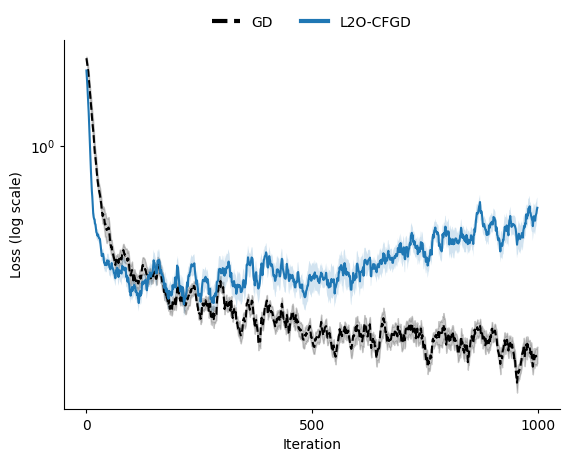

In [12]:
plot_metrics(
    baselines={
        k: r for k, r in runs.items() if "L2O-CFGD" not in k
    },
    l2os={
        k: r for k, r in runs.items() if "L2O-CFGD" in k
    },
    metrics=["loss"],
    # show_max_iters=200,
    log_metric=True,
    with_err_bars=True,
    conv_window=15,
    save_fig_to_path=None,
    # y_max=10**1/2,
)

In [ ]:
losses = []
for k, run_log in runs.items():
    if "loss" not in run_log["log"]:
        continue
    losses.append((k, np.array(run_log["log"]["loss"]).sum()))
for (k, l) in sorted(losses, key=lambda x: x[1]):
    print(k, "  ", l)

In [ ]:
conv_win = 20
plot_log(
    runs,
    only_metrics=["loss", "cos_sim(d, x.grad)"],
    log_metrics=["loss", "l2_dist(x_tik*, x)", "l2_dist(x*, x)"],
    conv_win=conv_win,
    min_max_y_config={
        "last_lr": (0, 100),
    },
    # save_to=os.path.join(
    #     config["ckpt_config"]["ckpt_dir"],
    #     f"loss_cos_sim_l2o_best_dict_1600_{conv_win}conv_{n_test_runs}runs_{test_run_iters}iters.png"
    # ),
)

In [ ]:
apply_publication_plt_settings(font_size=16, dpi=600, figsize=(5, 3.5))
apply_publication_plt_settings(font_size=15, dpi=600, figsize=(13, 8))

In [ ]:
hparams = dict()
for hyperparam_name in ("alpha", "beta", "c"):
    per_param_alphas = []
    for param_idx in range(len(runs["L2O-CFGD"]["log"][hyperparam_name][0][0])):
        per_param_alphas.append([])
        for i in range(len(runs["L2O-CFGD"]["log"][hyperparam_name])):
            per_param_alphas[-1].append([])
            for j in range(len(runs["L2O-CFGD"]["log"][hyperparam_name][i])):
                per_param_alphas[-1][-1].append(
                    runs["L2O-CFGD"]["log"][hyperparam_name][i][j][param_idx]
                )
    for param_idx in range(len(runs["L2O-CFGD"]["log"][hyperparam_name][0][0])):
        per_param_alphas[param_idx] = np.stack(per_param_alphas[param_idx]).reshape(n_test_runs, test_run_iters, -1)
    hparams[hyperparam_name] = per_param_alphas

In [ ]:
param_idx = 0
test_run_idx = 0
to_plot_name = "alpha"
plot_plot_label = r"$\alpha$"
log_plot = False
max_components = 400
component_idxs = np.random.choice(hparams[to_plot_name][param_idx].shape[-1], size=min(max_components, hparams[to_plot_name][param_idx].shape[-1]), replace=False)

In [ ]:
fig = plt.figure(figsize=(15, 6), facecolor="w")
fig.suptitle(rf"L2O-CFGD: {plot_plot_label}", fontsize=16)
ax = fig.add_subplot(121)
if to_plot_name == "alpha":
    to_plot = hparams["alpha"][param_idx][:,:,component_idxs]
elif to_plot_name == "beta":
    to_plot = hparams["beta"][param_idx][:,:,component_idxs]
elif to_plot_name == "c":
    to_plot = hparams["c"][param_idx][:,:,component_idxs]
else:
    raise ValueError(f"Unknown to_plot: {to_plot_name}")

plt.plot(to_plot[test_run_idx].squeeze().reshape(1000, -1), alpha=0.1, color="grey")
plt.plot(to_plot[test_run_idx].squeeze().reshape(1000, -1).mean(-1), color="orange", linewidth=3)
ax.set_xlabel("Iteration", fontsize=13)
ax.set_ylabel(plot_plot_label, fontsize=13)

### share y-axis with left plot
ax = fig.add_subplot(122, sharey=ax)
plt.plot(to_plot[test_run_idx].squeeze().reshape(1000, -1)[:,:3])
ax.set_xlabel("Iteration", fontsize=13)
ax.set_ylabel(plot_plot_label, fontsize=13)
ax.legend(["Parameter #1", "Parameter #2", "Parameter #3"])

if log_plot:
    ax.set_yscale("log")

plt.tight_layout(h_pad=2.5)
# save_to = os.path.join(
#     config["ckpt_config"]["ckpt_dir"],
#     f"strategy_{to_plot_name}_{n_test_runs}runs_{test_run_iters}iters.png"
# )
# fig.savefig(save_to)

# fig.savefig("../results/strategy.eps", bbox_inches="tight")

In [ ]:
test_run_idx = 0
iters_to_show = [0, 1, 2, 5, 20]

# fig = plt.figure(figsize=(14, 18), facecolor="white")
fig = plt.figure()
# fig.suptitle("L2O + CFGD_ClosedForm")
ax_idx = 1

for i, iter_idx in enumerate(iters_to_show):
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ### alphas
    sns.scatterplot(
        # x=grads[test_run_idx, iter_idx, component_idxs],
        # y=alphas[test_run_idx, iter_idx, component_idxs],
        x=grads[:, iter_idx, component_idxs],
        y=alphas[:, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$\alpha$")
    # ax.set_title(fr"Iteration {iter_idx}")

    ### betas
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx + 1)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    sns.scatterplot(
        x=grads[test_run_idx, iter_idx, component_idxs],
        y=betas[test_run_idx, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$\beta$")
    ax.set_title(fr"Iteration {iter_idx}", pad=10)
    # ax.set_title(fr"$\beta$ (iter {iter_idx})")

    ### cs
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx + 2)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    sns.scatterplot(
        x=grads[test_run_idx, iter_idx, component_idxs],
        y=cs[test_run_idx, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$c$")
    # ax.set_title(fr"$c$ (iter {iter_idx})")

    ax_idx += 3

# fig.tight_layout(h_pad=1.5)
# save_to = os.path.join(
#     config["ckpt_config"]["ckpt_dir"],
#     f"strategy_grad_alpha_beta_c_{test_d}d_{test_m}m_{n_test_runs}runs_{test_run_iters}iters.png"
# )
# fig.savefig(save_to)
plt.tight_layout(h_pad=2.2)
plt.show()

# fig.savefig("../results/strategy.eps", bbox_inches="tight")

In [ ]:
### save stats about the L2O-CFGD strategy
run_name_clean = ''.join(e for e in run_name if e.isalnum())
run_nickname = f"L2OCFGD__{dict_to_str(runs['L2O-CFGD']['config']['optee']['optee_config'])}__{n_test_runs}runs_{test_run_iters}iters_{test_runs_seed}seed"
save_to = os.path.join(runs["L2O-CFGD"]["config"]["ckpt_config"]["ckpt_dir"], run_nickname + "_hparams" + ".pt")

save_to = os.path.join(runs["L2O-CFGD"]["config"]["ckpt_config"]["ckpt_dir"], run_nickname + "_hparams" + ".pt")
torch.save({
    "hyperparams": hparams,
}, save_to, pickle_module=dill)

### Run LCFGD

In [ ]:
### collect
alphas = np.stack(hparams["alpha"][0]).reshape(n_test_runs, test_run_iters, -1)
alphas_mean = alphas.mean((0,2))
betas = np.stack(hparams["beta"][0]).reshape(n_test_runs, test_run_iters, -1)
betas_mean = betas.mean((0,2))
cs = np.stack(hparams["c"][0]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)
cs_mean = cs.mean((0,2))

In [ ]:
alphas_to_set = torch.ones(test_run_iters)
alphas_to_set[:20] = 0.1
alphas_to_set[20:40] = 0.6
alphas_to_set[40:100] = 0.95
alphas_to_set[100:] = 0.99

betas_to_set = torch.zeros(test_run_iters)
betas_to_set[:10] = -0.2
betas_to_set[10:40] = -0.1
betas_to_set[40:100] = 0.15
betas_to_set[100:] = 0.1

cs_to_set = torch.zeros(test_run_iters)
cs_to_set[:10] = -0.5
cs_to_set[10:40] = 0.
cs_to_set[40:] = 0.3

In [ ]:
# lcfgd_run_name = r"LCFGD-AT"
lcfgd_run_name = r"NA-CFGD (test)"
runs[lcfgd_run_name] = dict()
lcfgd_config = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": CFGD,
            "opter_config": {
                "lr": 0.1,
                "alpha": 0.98,
                # "alpha": torch.from_numpy(alphas_mean).to(DEVICE),
                # "alpha": alphas_to_set.to(DEVICE),

                # "beta": torch.from_numpy(betas_mean).to(DEVICE),
                "beta": 0.05,
                # "beta": betas_to_set.to(DEVICE),
                # "beta": 0,

                # "c": torch.from_numpy(cs_mean).to(DEVICE),
                # "c": cs_to_set.to(DEVICE),
                # "c": 1,
                # "c": 0.3,
                "c": 0,

                "s": 1,
                "version": "NA",
                "init_points": None,
                # "init_points": [
                #     [torch.randn_like(p, requires_grad=False, device=DEVICE)] for _, p in _tmp_optee.all_named_parameters()
                # ],
                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "linestyle": "dashed",
    },
}

In [ ]:
### run
runs[lcfgd_run_name]["config"] = copy.deepcopy(config)
runs[lcfgd_run_name]["config"].update(lcfgd_config["update_config"])
runs[lcfgd_run_name]["config"]["data"]["data_config"]["device"] = DEVICE
runs[lcfgd_run_name]["plot_config"] = lcfgd_config["plot_config"]
runs[lcfgd_run_name]["config"]["device"] = DEVICE

lcfgd_log = do_fit(
    opter_cls=runs[lcfgd_run_name]["config"]["opter"]["opter_cls"],
    opter_config=runs[lcfgd_run_name]["config"]["opter"]["opter_config"],
    optee_cls=runs[lcfgd_run_name]["config"]["optee"]["optee_cls"],
    optee_config=runs[lcfgd_run_name]["config"]["optee"]["optee_config"],
    data_cls=runs[lcfgd_run_name]["config"]["data"]["data_cls"],
    data_config=runs[lcfgd_run_name]["config"]["data"]["data_config"],
    n_iters=runs[lcfgd_run_name]["config"]["n_iters"],
    l2o_dict=runs[lcfgd_run_name]["config"]["l2o_dict"],
    in_meta_training=False,
    additional_metrics=runs[lcfgd_run_name]["config"]["additional_metrics"],
    device=DEVICE,
)[0]

### append log
runs[lcfgd_run_name]["log"] = dict()
for metric_name in lcfgd_log.keys():
    if metric_name not in runs[lcfgd_run_name]["log"]:
        runs[lcfgd_run_name]["log"][metric_name] = []
    runs[lcfgd_run_name]["log"][metric_name].append(lcfgd_log[metric_name])

In [ ]:
plot_metric(
    baselines={
        k: r for k, r in runs.items()
        if "L2O-CFGD" not in k and "LCFGD" not in k
    },
    l2os={
        k: r for k, r in runs.items()
        if "L2O-CFGD" in k or "LCFGD" in k
    },
    metric="loss",
    show_max_iters=1000,
    log_metric=True,
    with_err_bars=True,
    conv_window=10,
    save_fig_to_path=None,
)

In [ ]:
### reorder runs
# runs = {
#     "GD": runs["GD"],
#     "L2O-CFGD": runs["L2O-CFGD"],
# }

### clear runs
ks = list(runs.keys())
for k in ks:
    if "lcfgd" in k.lower():
        del runs[k]